In [1]:
import pandas as pd

df = pd.read_csv('European_Restaurant_Reviews_with_Sentiment.csv')

In [2]:
def map_to_binary(sentiment):
    if sentiment in ["Muito Negativo", "Negativo","Negative"]:
        return "Negativo"
    elif sentiment in ["Positivo", "Muito Positivo","Positive"]:
        return "Positivo"
    else:
        return None  # Ignorar "Neutro"

In [3]:
# Mapeia as predições
y_pred_binary = [map_to_binary(s) for s in df['Sentimento']]
# Mapeia os rótulos verdadeiros
y_true_binary = [map_to_binary(s) for s in df['Sentiment']]

y_true_final = []
y_pred_final = []

for yt, yp in zip(y_true_binary, y_pred_binary):
    if yt is not None and yp is not None:
        y_true_final.append(yt)
        y_pred_final.append(yp)

In [4]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc = accuracy_score(y_true_final, y_pred_final)
f1 = f1_score(y_true_final, y_pred_final, average='binary', pos_label="Positivo")

print(f"Acurácia: {acc:.4f}")
print(f"F1-score (binário): {f1:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_true_final, y_pred_final, target_names=["Negativo", "Positivo"]))


Acurácia: 0.9747
F1-score (binário): 0.9854

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.95      0.86      0.90       169
    Positivo       0.98      0.99      0.99      1054

    accuracy                           0.97      1223
   macro avg       0.96      0.93      0.94      1223
weighted avg       0.97      0.97      0.97      1223



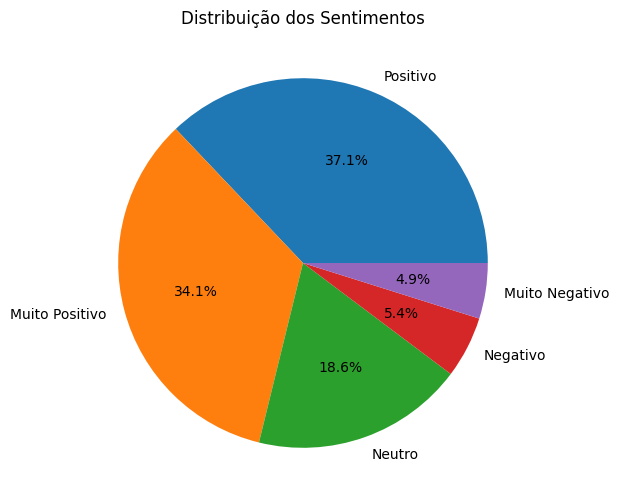

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.pie(df['Sentimento'].value_counts(), labels=df['Sentimento'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribuição dos Sentimentos')
plt.show()

In [6]:
print(df[df["Sentimento"] == "Muito Negativo"]["Review"])

0       The manager became agressive when I said the c...
1       I ordered a beef fillet ask to be done medium,...
5       We visited this restaurant on Saturday night a...
8       We got the Tasting Menu and wine pairing. Fran...
19      Service is fine, decor fine, but the food is e...
                              ...                        
1468    This place like the rest of Cuba was filthy an...
1471    Save yourself some $$$ and go somewhere like S...
1491    for terrible service of a truly comedic level,...
1495    Beautiful in the square and up to two blocks o...
1499    for terrible service of a truly comedic level,...
Name: Review, Length: 73, dtype: object


/home/mateus/TP2.IA/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


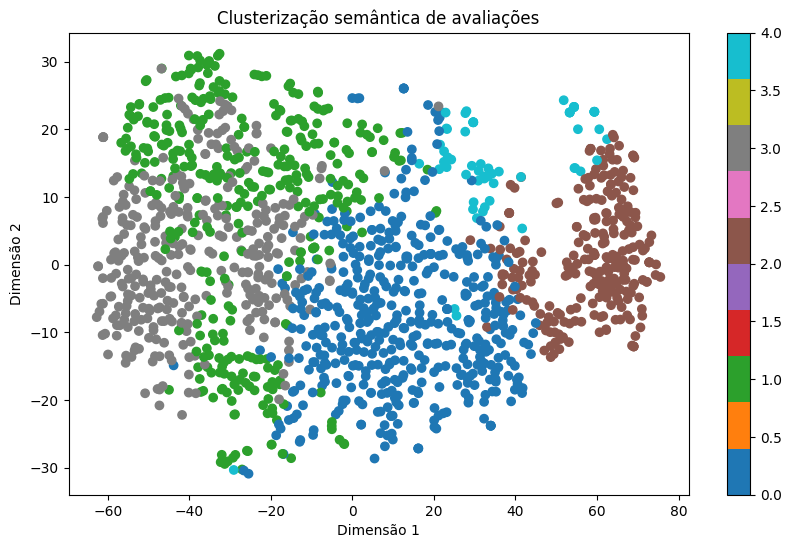

In [7]:
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import torch

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # [CLS] token
            embeddings.append(cls_embedding)
    return embeddings

from sklearn.cluster import KMeans
import numpy as np

df = pd.read_csv("European_Restaurant_Reviews_with_Sentiment.csv")
texts = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()

embeddings = get_embeddings(texts)  # texts = lista de textos processados
embeddings = np.array(embeddings) 
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Adiciona ao dataframe
df['cluster'] = clusters

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='tab10')
plt.title("Clusterização semântica de avaliações")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar()
plt.show()

In [8]:
df['cluster'] = clusters

In [9]:
print(df['cleaned_review_tokens'].head())

0    ['manager', 'became', 'agressive', 'said', 'ca...
1    ['ordered', 'beef', 'fillet', 'ask', 'done', '...
2    ['attractive', 'venue', 'welcoming', 'albeit',...
3    ['sadly', 'used', 'high', 'tripadvisor', 'rati...
4    ['start', 'meal', 'bad', 'especially', 'given'...
Name: cleaned_review_tokens, dtype: object


In [10]:
df['text_str'] = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens))

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

n_words = 10
top_palavras_df = []

for cluster_id in sorted(df['cluster'].unique()):
    textos = df[df['cluster'] == cluster_id]['text_str']
    
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(textos)
    
    # Soma os pesos de cada termo no cluster
    scores = X.toarray().sum(axis=0)
    termos = vectorizer.get_feature_names_out()
    
    # Cria ranking
    top_indices = scores.argsort()[::-1][:n_words]
    for idx in top_indices:
        top_palavras_df.append({
            "cluster": cluster_id,
            "palavra": termos[idx],
            "peso": scores[idx]
        })


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
import plotly.express as px

df_top = pd.DataFrame(top_palavras_df)

fig = px.bar(
    df_top,
    x="peso",
    y="palavra",
    color="cluster",
    orientation="h",
    facet_row="cluster",
    title="Palavras mais relevantes por cluster (TF-IDF)",
    height=200 + 150 * df_top['cluster'].nunique()
)

fig.update_layout(
    showlegend=False,
    margin=dict(l=120, r=20, t=30, b=20)
)
fig.update_yaxes(categoryorder="total ascending")

fig.show()
